In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE


In [2]:
df_client4 = pd.read_csv("client_4_binary.csv")

In [ ]:
df_client4.shape()

In [3]:
df_client4.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,4.0,28.0,3.0,0.0,1.0,4.0,6.0,7.0
1,0.0,1.0,1.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,1.0,7.0,0.0,1.0,9.0,4.0,8.0
2,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,7.0
3,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,13.0,4.0,5.0
4,0.0,1.0,1.0,1.0,33.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,9.0,5.0,7.0


In [4]:
df_client4["Diabetes_binary"].value_counts()

Diabetes_binary
0.0    54587
1.0     8833
Name: count, dtype: int64

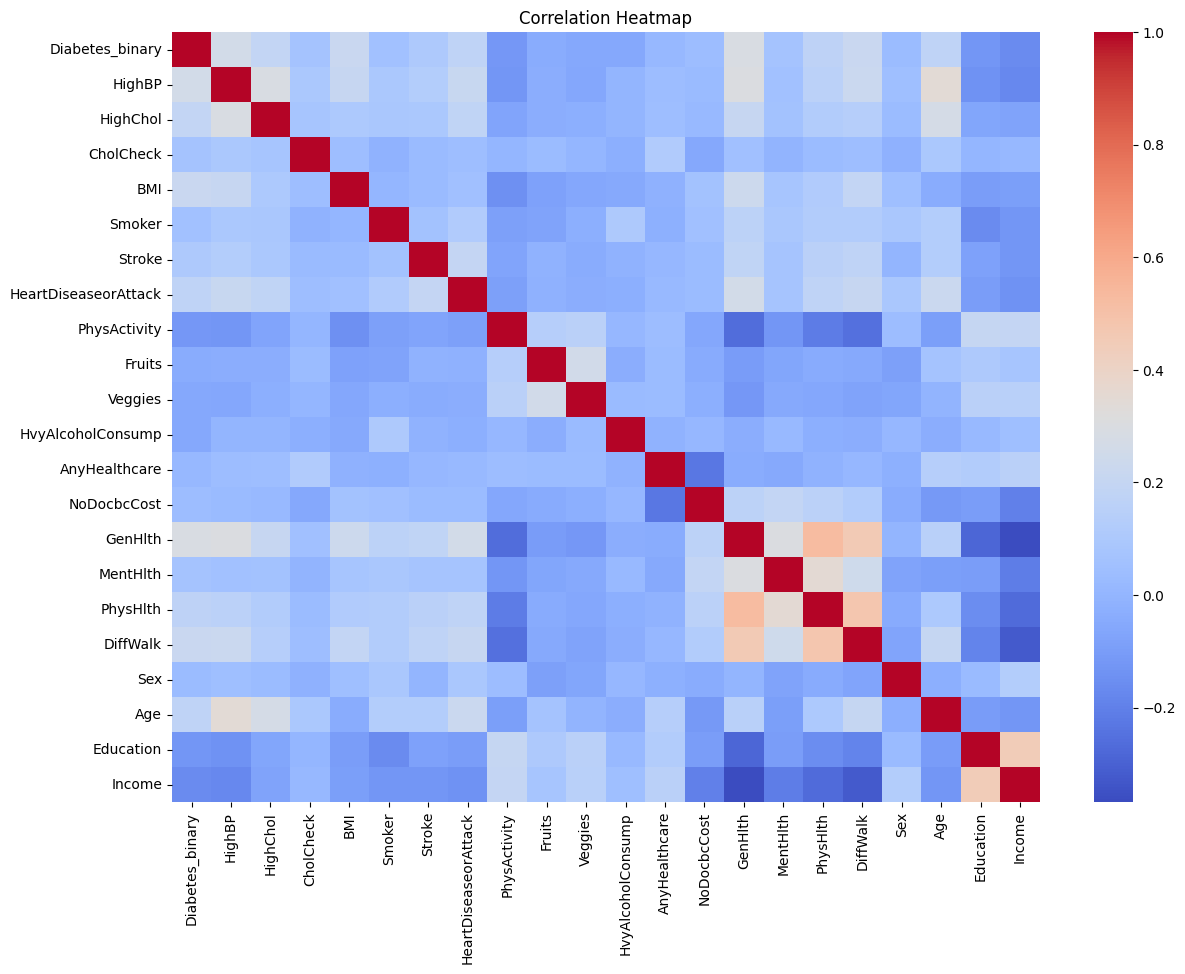

In [5]:
plt.figure(figsize=(14,10))
sns.heatmap(df_client4.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


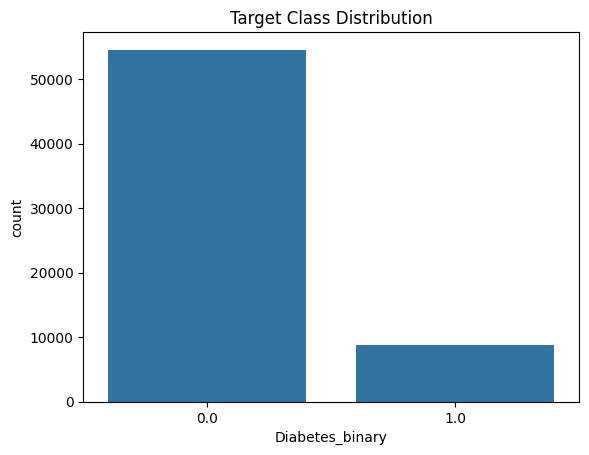

In [6]:
sns.countplot(x='Diabetes_binary', data=df_client4)
plt.title("Target Class Distribution")
plt.show()


In [7]:
X = df_client4.drop('Diabetes_binary', axis=1)
y = df_client4['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


**Global model**

In [8]:
!python -m pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import mysql.connector
import pickle
from sklearn.linear_model import LogisticRegression
conn_config = {
    'host': '127.0.0.1',
    'user': 'centralAuth',
    'password': 'messi10',
    'database': 'fl_database'
}
conn = mysql.connector.connect(**conn_config)
cursor = conn.cursor()
cursor.execute("SELECT model_blob FROM central_updates WHERE model_id = %s AND version = %s", (1, 1))
result = cursor.fetchone()
cursor.close()
conn.close()
if result is None:
    raise Exception("Model not found in database.")
model_blob = result[0]
model_blob

b'\x80\x04\x95K\x01\x00\x00\x00\x00\x00\x00\x8c\x1esklearn.linear_model._logistic\x94\x8c\x12LogisticRegression\x94\x93\x94)\x81\x94}\x94(\x8c\x07penalty\x94\x8c\x02l2\x94\x8c\x04dual\x94\x89\x8c\x03tol\x94G?\x1a6\xe2\xeb\x1cC-\x8c\x01C\x94G?\xf0\x00\x00\x00\x00\x00\x00\x8c\rfit_intercept\x94\x88\x8c\x11intercept_scaling\x94K\x01\x8c\x0cclass_weight\x94\x8c\x08balanced\x94\x8c\x0crandom_state\x94N\x8c\x06solver\x94\x8c\x05lbfgs\x94\x8c\x08max_iter\x94M\xf4\x01\x8c\x0bmulti_class\x94\x8c\x0bmultinomial\x94\x8c\x07verbose\x94K\x00\x8c\nwarm_start\x94\x89\x8c\x06n_jobs\x94N\x8c\x08l1_ratio\x94N\x8c\x10_sklearn_version\x94\x8c\x051.5.2\x94ub.'

In [11]:
if isinstance(model_blob, str):
    model_blob = model_blob.encode('latin1')  # Or 'utf-8' if needed
model = pickle.loads(model_blob)
model

LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial')

In [12]:
model1 = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')
model1.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [13]:
y_pred = model1.predict(X_test)
y_proba = model1.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[7886 3031]
 [ 373 1394]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     10917
         1.0       0.32      0.79      0.45      1767

    accuracy                           0.73     12684
   macro avg       0.63      0.76      0.64     12684
weighted avg       0.87      0.73      0.77     12684

ROC AUC Score: 0.8315864226128944


In [15]:


import mysql.connector
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, log_loss

import pickle
from sklearn.metrics import classification_report

# Sample values (replace with dynamic evaluation if needed)
accuracy = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, y_proba)

# Model serialization
model_blob = pickle.dumps(model1)

print(classification_report(y_test, y_pred))
# Classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)
report



              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     10917
         1.0       0.32      0.79      0.45      1767

    accuracy                           0.73     12684
   macro avg       0.63      0.76      0.64     12684
weighted avg       0.87      0.73      0.77     12684



{'0.0': {'precision': 0.9548371473544013,
  'recall': 0.7223596226069433,
  'f1-score': 0.8224864413850647,
  'support': 10917.0},
 '1.0': {'precision': 0.3150282485875706,
  'recall': 0.788907753254103,
  'f1-score': 0.4502583979328165,
  'support': 1767.0},
 'accuracy': 0.7316304005045727,
 'macro avg': {'precision': 0.634932697970986,
  'recall': 0.7556336879305232,
  'f1-score': 0.6363724196589406,
  'support': 12684.0},
 'weighted avg': {'precision': 0.8657057752225037,
  'recall': 0.7316304005045727,
  'f1-score': 0.7706315885957141,
  'support': 12684.0}}

In [16]:
# Extract metrics
macro_f1 = report["macro avg"]["f1-score"]
recall_minority = report["1.0"]["recall"]
f1_minority = report["1.0"]["f1-score"]
f1_majority = report["0.0"]["recall"]
f1_minority

0.4502583979328165

In [17]:

macro_f1 = report["macro avg"]["f1-score"]
recall_minority = report["1.0"]["recall"]
f1_minority = report["1.0"]["f1-score"]
f1_majority = report["0.0"]["recall"]
f1_minority



fit_status = "good"

# DB Insert Details
model_id = 1
client_id = "4"
round_num = 2

# DB Connection
conn = mysql.connector.connect(
    host="127.0.0.1",
    user="centralAuth",
    password="messi10",
    database="fl_database"
)
cursor = conn.cursor()

# Updated insert query
insert_query = """
INSERT INTO client_updates 
(model_id, client_id, model_blob, accuracy, loss, round_num, macro_f1, recall_minority, f1_minority, f1_majority, fit_status)
VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

# Execute Insert
cursor.execute(insert_query, (
    model_id, client_id, model_blob, accuracy, loss, round_num,
    macro_f1, recall_minority, f1_minority, f1_majority, fit_status
))
conn.commit()

print(" Model update inserted successfully with classification metrics.")

cursor.close()
conn.close()



 Model update inserted successfully with classification metrics.
